## Objective: Identify Metastatic Cells

Our objective is to train a CNN classifier to accurately identify the presence of metastatic cancerous tissue in histopathologic scans of lymph node sections. 

We will train our model on the PCam dataset which has been slightly modified by Kaggle for its competition. 

In [1]:
import numpy as np
import pandas as pd

import os
import tqdm
import keras
import sys

#set seed
keras.utils.set_random_seed(8122)

#Visualization Libraries
import matplotlib.pyplot as plt
from PIL import Image
sys.modules['Image'] = Image 
import seaborn as sns

#Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Model Libraries
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import BatchNormalization, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dense, Activation
from tensorflow.keras.models import Sequential

#Optimization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, Adagrad

import keras_tuner

#model comparison
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score




### Data Preprocessing & Evaluation

In [2]:
#confirm GPU access
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_labels = pd.read_csv('train_labels.csv')

num_train_labels = train_labels.shape[0]
num_train_files = len([file for file in os.listdir('train')])

num_test_files = len([file for file in os.listdir('test')])

print(f"There are {num_train_labels} labels in the train_label dataframe.")
print(f"There are {num_train_files} .tif files in the provided 'train' directory.")

print(f"There are {num_test_files} .tif files in the provided 'test' directory, making up approximately {round(100 *(num_test_files/(num_test_files + num_train_files)), 2)}% of the total dataset.")


There are 220025 labels in the train_label dataframe.
There are 220025 .tif files in the provided 'train' directory.
There are 57458 .tif files in the provided 'test' directory, making up approximately 20.71% of the total dataset.


In [4]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


We can see from the above that the dataframe holds 22,005 ids and labels (matching the number of images we have in the training date) and that there are no null rows. The dataframe consists of a column of ids corresponding to the .tif images and a column of true labels to train our model.

A label of 1 corresponds to the presence of metastatic tissue while a label of 0 corresponds to no metastatic tissue found. 

This shows that our problem is a binary classification problem. 

We can review some of the image files below:

Tiff Image sizes are 96x96
Three (enlarged) example histopathologic Images from the training data:



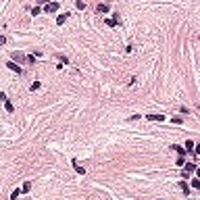

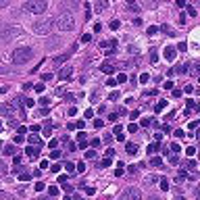

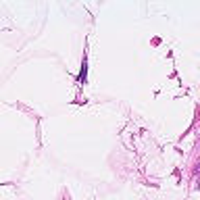

In [5]:
imgs = [os.path.join('train',sample +'.tif') for sample in train_labels.sample(3)['id']]

examp_img = Image.open(imgs[1])
img_w = examp_img.width
img_h = examp_img.height
print(f"Tiff Image sizes are {img_w}x{img_h}")

print(f"Three (enlarged) example histopathologic Images from the training data:\n")
for img in imgs:
    display(Image.open(img).resize((200,200)))



### Transforming Data to Tensors for Model Training

In [6]:
train_path = './train/'
df = train_labels
df['label'] = df['label'].astype(str)
df['id'] = df['id'].apply(lambda x:  x + '.tif')



In [7]:
##### 
### NOTE: ImageDataGenerator is deprecated, however, the preferred image preprocessing module
### in Keras does not have compatability with .tif images. Accordingly, we are forced to use
### ImageDataGenerator until the recommended module is updated.
####


datagen = ImageDataGenerator(rescale=1./255., #normalize pixel values for better performance
                            validation_split=0.2)

batch_size = 256

train_ds = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=batch_size,
    target_size=(64,64),
    seed=13,
    class_mode="binary",
    shuffle=True)

val_ds = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=batch_size,
    target_size=(64,64),
    seed=13,
    class_mode="binary",
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [8]:
early_stopping = EarlyStopping(patience=3, #early stopping if val_loss worsens <patience> number of times.
                        restore_best_weights=True) #restores the weights from the best iteration during training

# Building Models - 2 Approaches

### Convolution Layer Only Approach

Firstly, we will attempt to tackle our objective using a model that relies on 4 convolution layers fed directly to an output layer with a sigmoid activation function. Limiting ourselves to convolution layers, rather than adding additional dense layers for classification tasks, may help to reduce overhead and potentially limit overfitting.

Our architecture will follow recommendations made in class with 2 convolution layers followed by a max pooling layer forming the basic block of our network.


In [9]:
conv_model = Sequential()
        
conv_model.add(Conv2D(filters=32, kernel_size=(3,3)))
conv_model.add(Conv2D(filters=32, kernel_size=(3,3)))
conv_model.add(MaxPooling2D(pool_size=(2,2)))

conv_model.add(Conv2D(filters=64, kernel_size=(3,3)))
conv_model.add(Conv2D(filters=64, kernel_size=(3,3)))
conv_model.add(MaxPooling2D(pool_size=(2,2)))

conv_model.add(Flatten())
conv_model.add(Dense(1, activation='sigmoid'))
    
conv_model.build(input_shape=(32, 64, 64, 3))

In [10]:
ROC_score =  tf.keras.metrics.AUC(name='ROC') #ROC metric for competition
opt = Adagrad(learning_rate=0.001) #Adagrad optimizer

conv_model.compile(loss='binary_crossentropy', 
              optimizer=opt,
              metrics=['accuracy', ROC_score])
    
conv_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 62, 62, 32)          896       
                                                                 
 conv2d_1 (Conv2D)           (32, 60, 60, 32)          9248      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 30, 30, 32)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (32, 28, 28, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (32, 26, 26, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 13, 13, 64)         0         
 2D)                                                    

In [11]:
#Train the model

total_epochs = 10

conv_history = conv_model.fit(
                    train_ds,
                    epochs = total_epochs,
                    validation_data = val_ds,
                    callbacks = [early_stopping],
                    verbose=1)

Epoch 1/10
688/688 [==============================] - 77s 107ms/step - loss: 0.6306 - accuracy: 0.6391 - ROC: 0.6842 - val_loss: 0.5839 - val_accuracy: 0.7016 - val_ROC: 0.7562
Epoch 2/10
688/688 [==============================] - 73s 106ms/step - loss: 0.5740 - accuracy: 0.7169 - ROC: 0.7663 - val_loss: 0.5612 - val_accuracy: 0.7316 - val_ROC: 0.7849
Epoch 3/10
688/688 [==============================] - 73s 105ms/step - loss: 0.5612 - accuracy: 0.7301 - ROC: 0.7840 - val_loss: 0.5562 - val_accuracy: 0.7364 - val_ROC: 0.7914
Epoch 4/10
688/688 [==============================] - 72s 105ms/step - loss: 0.5560 - accuracy: 0.7342 - ROC: 0.7903 - val_loss: 0.5519 - val_accuracy: 0.7359 - val_ROC: 0.7956
Epoch 5/10
688/688 [==============================] - 73s 106ms/step - loss: 0.5521 - accuracy: 0.7370 - ROC: 0.7948 - val_loss: 0.5479 - val_accuracy: 0.7388 - val_ROC: 0.7995
Epoch 6/10
688/688 [==============================] - 74s 107ms/step - loss: 0.5481 - accuracy: 0.7403 - ROC: 0.798

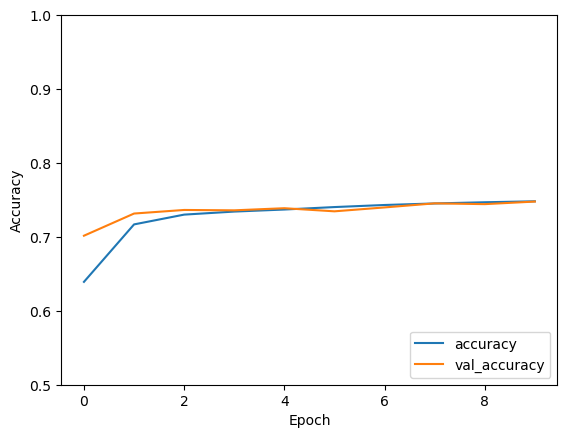

In [12]:
plt.plot(conv_history.history['accuracy'], label='accuracy')
plt.plot(conv_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


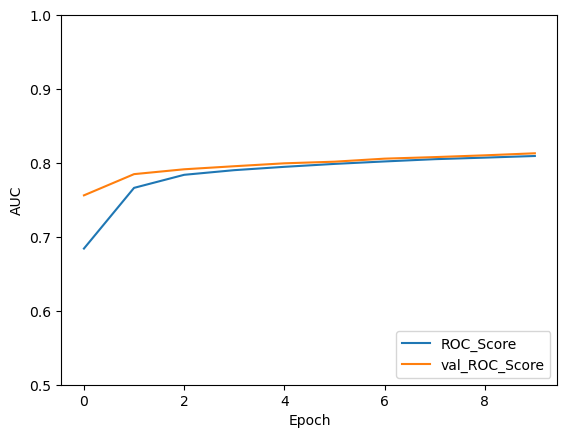

In [13]:
plt.plot(conv_history.history['ROC'], label='ROC_Score')
plt.plot(conv_history.history['val_ROC'], label = 'val_ROC_Score')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Adding Dense Layers for Classification

We can add one more dense layer to see if that improves the ROC score for classification. An additional dense layer may help the model in the classification task while, unfortunately, adding to the processing overhead and time for training.

In [14]:
conv_dense = Sequential()
    
conv_dense.add(Conv2D(filters=32, kernel_size=(3,3)))
conv_dense.add(Conv2D(filters=32, kernel_size=(3,3)))
conv_dense.add(MaxPooling2D(pool_size=(2,2)))

conv_dense.add(Conv2D(filters=64, kernel_size=(3,3)))
conv_dense.add(Conv2D(filters=64, kernel_size=(3,3)))
conv_dense.add(MaxPooling2D(pool_size=(2,2)))

#Additional Dense layer to train classifier
conv_dense.add(Dense(64, activation='relu'))

#flatten and prepare sigmoid activation
conv_dense.add(Flatten())
conv_dense.add(Dense(1, activation='sigmoid'))
    
conv_dense.build(input_shape=(32, 64, 64, 3))



In [15]:
opt = Adagrad(learning_rate=0.001) #Adagrad optimizer
ROC_score =  tf.keras.metrics.AUC(name='ROC') #ROC metric for competition

conv_dense.compile(loss='binary_crossentropy', 
               optimizer=opt,
               metrics=['accuracy', ROC_score])
    
conv_dense.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (32, 62, 62, 32)          896       
                                                                 
 conv2d_5 (Conv2D)           (32, 60, 60, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 30, 30, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (32, 28, 28, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (32, 26, 26, 64)          36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 13, 13, 64)         0         
 2D)                                                  

In [16]:
#Train the model

total_epochs = 10

conv_dense_history = conv_dense.fit(
                        train_ds,
                        epochs = total_epochs,
                        validation_data = val_ds,
                        callbacks = [early_stopping],
                        verbose=1)

Epoch 1/10
688/688 [==============================] - 73s 106ms/step - loss: 0.5997 - accuracy: 0.6720 - ROC: 0.7419 - val_loss: 0.5135 - val_accuracy: 0.7600 - val_ROC: 0.8276
Epoch 2/10
688/688 [==============================] - 74s 107ms/step - loss: 0.4854 - accuracy: 0.7798 - ROC: 0.8422 - val_loss: 0.4733 - val_accuracy: 0.7842 - val_ROC: 0.8500
Epoch 3/10
688/688 [==============================] - 74s 108ms/step - loss: 0.4712 - accuracy: 0.7858 - ROC: 0.8509 - val_loss: 0.4670 - val_accuracy: 0.7885 - val_ROC: 0.8544
Epoch 4/10
688/688 [==============================] - 74s 108ms/step - loss: 0.4654 - accuracy: 0.7879 - ROC: 0.8550 - val_loss: 0.4613 - val_accuracy: 0.7887 - val_ROC: 0.8580
Epoch 5/10
688/688 [==============================] - 74s 107ms/step - loss: 0.4609 - accuracy: 0.7900 - ROC: 0.8583 - val_loss: 0.4572 - val_accuracy: 0.7918 - val_ROC: 0.8605
Epoch 6/10
688/688 [==============================] - 74s 108ms/step - loss: 0.4572 - accuracy: 0.7925 - ROC: 0.860

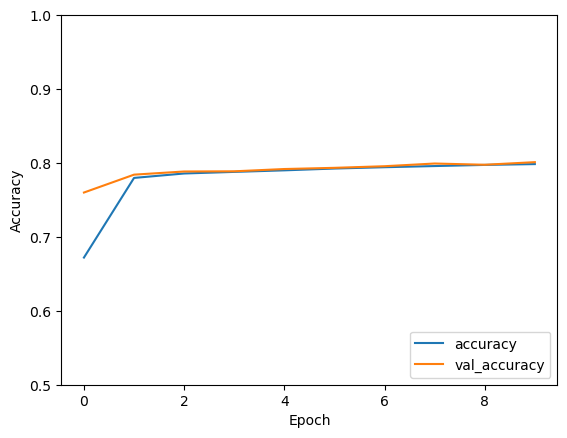

In [17]:
plt.plot(conv_dense_history.history['accuracy'], label='accuracy')
plt.plot(conv_dense_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

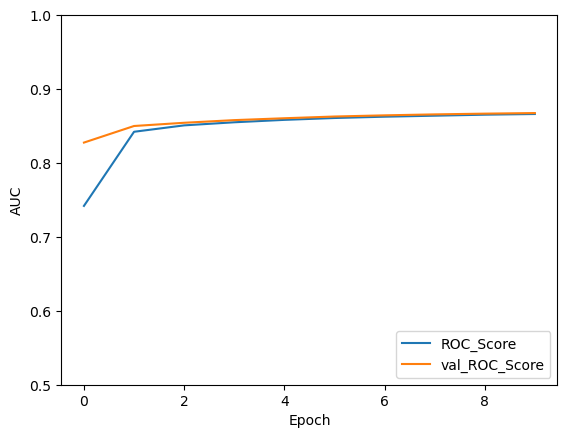

In [18]:
plt.plot(conv_dense_history.history['ROC'], label='ROC_Score')
plt.plot(conv_dense_history.history['val_ROC'], label = 'val_ROC_Score')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Comparing Approaches

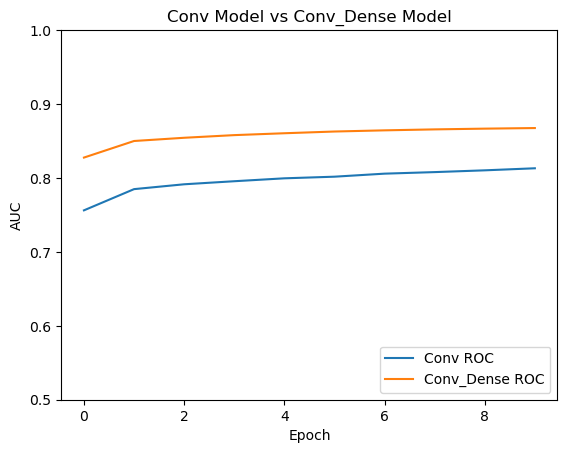

In [19]:
plt.plot(conv_history.history['val_ROC'], label='Conv ROC')
plt.plot(conv_dense_history.history['val_ROC'], label = 'Conv_Dense ROC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Conv Model vs Conv_Dense Model')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We can see from the above plot that adding an additional dense layer improved the ROC metric consistently throughout training. Including a dense layer may have helped the model's classification based on the feature maps produced by the convolutional layers.



In [20]:
metrics = pd.DataFrame(columns=["Loss", "Accuracy", "ROC"])

metrics.loc['conv_model'] = conv_model.evaluate(val_ds)

metrics.loc['conv_dense'] = conv_dense.evaluate(val_ds)

172/172 [==============================] - 14s 84ms/step - loss: 0.4467 - accuracy: 0.8011 - ROC: 0.8675


In [21]:
metrics

,Loss,Accuracy,ROC
conv_model,0.532322,0.747779,0.813095
conv_dense,0.446734,0.801091,0.867518


The above metric comparison table further confirms our findings: the added dense layer improves the model's accuracy and ROC score.

We can further explore the differences and potentials of the dense layer, as well as hyperparameters, with hyperparameter tuning using keras_tuner.

## Hyperparameter Tuning with keras_tuner

We will use keras_tuner to find the optimal number of convulutional layers, dense layers, and learning rate using the code below.

In [22]:
def build_model(hp):
    """
    This function builds a CNN with hyperparameter
    tuning using keras_tuner.
    """
    
    model = Sequential()
    
    for i in range(hp.Int("num_conv_layers", 1, 3)):
        
        model.add(Conv2D(filters=hp.Int(f"conv_{i} first filter size", 32, 128, step=32), kernel_size=(3,3)))
        model.add(Conv2D(filters=hp.Int(f"conv_{i} second filter size", 32, 128, step=32), kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
    
    if hp.Boolean("dense_layer"):
        #Additional Dense layer to train classifier
        with hp.conditional_scope("dense_layer", True):
            model.add(Dense(hp.Int("dense_units", 32, 256, step=32), activation='relu'))

    #flatten and prepare sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    model.build(input_shape=(32, 64, 64, 3))
    
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    ROC_score =  tf.keras.metrics.AUC(name='ROC') #ROC metric for competition

    model.compile(loss='binary_crossentropy', 
               optimizer=Adam(learning_rate=learning_rate),
               metrics=['accuracy', ROC_score]
                      )
    
    return model


In [25]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    max_trials = 20,
    overwrite=True,
    objective="val_accuracy",
    directory="./",
    project_name="cnn_tuning",
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
conv_0 first filter size (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_0 second filter size (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_layer (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [26]:
### Perform the search over the hyperparameter space

tuner.search(train_ds, 
             epochs=30,
             validation_data=val_ds,
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=3)]
            )

Trial 20 Complete [00h 14m 16s]
val_accuracy: 0.5961368083953857

Best val_accuracy So Far: 0.8688103556632996
Total elapsed time: 03h 57m 28s


In [27]:
## Retrieve summary of best trials 

tuner.results_summary()

Results summary
Results in ./cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 13 summary
Hyperparameters:
num_conv_layers: 2
conv_0 first filter size: 32
conv_0 second filter size: 64
dense_layer: True
lr: 0.0004542805978770659
dense_units: 160
conv_1 first filter size: 32
conv_1 second filter size: 32
conv_2 first filter size: 32
conv_2 second filter size: 128
Score: 0.8688103556632996

Trial 08 summary
Hyperparameters:
num_conv_layers: 2
conv_0 first filter size: 96
conv_0 second filter size: 32
dense_layer: True
lr: 0.000585020145627166
dense_units: 96
conv_1 first filter size: 32
conv_1 second filter size: 32
conv_2 first filter size: 96
conv_2 second filter size: 32
Score: 0.8639018535614014

Trial 07 summary
Hyperparameters:
num_conv_layers: 1
conv_0 first filter size: 32
conv_0 second filter size: 32
dense_layer: True
lr: 0.0006555579174348286
dense_units: 160
conv_1 first filter size: 96
conv_1 second filter size: 64
conv_2 first filter s

In [28]:
## Retrieve the best model from keras tuner

models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 62, 62, 32)          896       
                                                                 
 conv2d_1 (Conv2D)           (32, 60, 60, 64)          18496     
                                                                 
 max_pooling2d (MaxPooling2D  (32, 30, 30, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (32, 28, 28, 32)          18464     
                                                                 
 conv2d_3 (Conv2D)           (32, 26, 26, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 13, 13, 32)         0         
 2D)                                                    

In [29]:
metrics.loc['tuned__model'] = best_model.evaluate(val_ds)
metrics

172/172 [==============================] - 16s 92ms/step - loss: 0.3132 - accuracy: 0.8688 - ROC: 0.9377


,Loss,Accuracy,ROC
conv_model,0.532322,0.747779,0.813095
conv_dense,0.446734,0.801091,0.867518
tuned__model,0.313216,0.868810,0.937655


## Conclusions

We can see that the keras_tuner chose an architecture of 4 convolution layers with 2 max pools and a dense layer before the final output layer. 

The tuned model has a much better accuracy than previous models, jumping 6 percentage points. Additionally, its AUC jumps 6 points from the second best model. Hyperparamter tuning clearly assisted in finding an optimal architecture for this classification problem.


## Preparing best model to submit predictions on Test Data for Kaggle Evaluation

In [47]:
TEST_PATH = 'test_images'

datagen = ImageDataGenerator(rescale=1./255.) #normalize pixel values for better performance

test_gen = datagen.flow_from_directory(TEST_PATH,
                                        target_size=(64,64),
                                        batch_size=1,
                                        class_mode=None,
                                        shuffle=False)



Found 57458 images belonging to 1 classes.


In [49]:
predictions = best_model.predict(test_gen)

57458/57458 [==============================] - 201s 4ms/step


In [56]:
predictions = np.where(predictions > .5, 1, 0)


In [57]:
ids = [filename for filename in os.listdir('test_images/test')]

cleaned = []

for id in ids:
    clean_id = id.split(".tif")[0]

    cleaned.append(clean_id)




In [60]:
submission = pd.DataFrame(columns=["id", "label"])

submission['id'] = cleaned
submission['label'] = predictions

submission.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [62]:
submission.to_csv('./submission.csv')